<a href="https://colab.research.google.com/github/CameronRobsonLeigh/Vector-Space-Semantics/blob/main/ec21948submission_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [ ]:
import string
import re
!pip install more-itertools
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import nltk
!pip install contractions
import contractions
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('all')
from sklearn.feature_extraction import DictVectorizer
from nltk.featstruct import remove_variables
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk import pos_tag
from nltk import bigrams
from nltk import trigrams
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
import random
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
pd.options.display.max_colwidth=500

     |████████████████████████████████| 284 kB 5.0 MB/s 
     |████████████████████████████████| 321 kB 59.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85441 sha256=de07fdb381c3ea68d5df705ad3b9e9acbd0ef38d322818f99546aa20a729ad9f
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [ ]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(1 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [ ]:
def GetLines(iterable):
    iterator = iter(iterable) # create iterable instance of our list. (dataframe)
    prev_item = None # set to none as default
    current_item = next(iterator)  # throws StopIteration if empty.
    for next_item in iterator: # loop through our dataframe
        yield (prev_item, current_item, next_item) # so we don't destroy states of local variables
        prev_item = current_item
        current_item = next_item
    yield (prev_item, current_item, None) # if no elem after set to none.

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    scenes = []
    prevLine = []
    nextLine = []
    sceneIndicator = 0
    sceneIndicator2 = 0
    count = 0
    i = 0
    # for morning - bring through scene info aswell.
    for episode, scene, line, gender, name, currentScene in zip(df.Episode,GetLines(df.Scene), GetLines(df.Line), df.Gender, GetLines(df.Character_name), df.Scene_info):
        count += 1
        if not name[1] in character_docs.keys():
            character_docs[name[1]] = ""
            character_line_count[name[1]] = 0
        if character_line_count[name[1]]==max_line_count:
            continue

        # logic to retrieve previous and next words
        if scene[1] != scene[2] and count != 1: # if our current scene number is not the same as our next scene number AND not our first iteration then continue
            sceneIndicator = 0 # reset variables
            sceneIndicator2 = 1
            character_docs[name[1]] +=  str(line[0]) + " " + str(line[1]) + " " + "ENDOFSCENE" + " " + " _EOL_ "
            character_line_count[name[1]]+=1
        else:
          if sceneIndicator2 == 1:
            character_docs[name[1]] +=  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
            character_line_count[name[1]]+=1
            sceneIndicator2 = 0
          else:
            if count == 1: # first iteration check
              character_docs[name[1]] +=   "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name[1]]+=1
            else:
              character_docs[name[1]] += str(line[0]) + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name[1]]+=1

    print("lines per character", character_line_count)
    return character_docs


In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  10149
OTHER Number of Words:  8334
JACK Number of Words:  10248
RONNIE Number of Words:  10405
TANYA Number of Words:  9794
SEAN Number of Words:  9885
ROXY Number of Words:  10200
HEATHER Number of Words:  10967
MAX Number of Words:  10409
IAN Number of Words:  10786
JANE Number of Words:  10178
STACEY Number of Words:  10473
PHIL Number of Words:  11112
MINTY Number of Words:  11060
CHRISTIAN Number of Words:  9931
CLARE Number of Words:  10362
total words 164293


In [ ]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    """
    my_punctuation = punctuation.replace("#", "")
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    #lemmatize the text so we break down words in their correct context
    tokenLemmed = lemmatizer.lemmatize(character_text)

    # remove all punctuation using translate and maketrans functions
    tokenPuncStrip = tokenLemmed.translate(str.maketrans('', '', my_punctuation))
    #we stem the words which the lemmatizer has done for context words but now we break down further as the context has already been sorted.
    tokenStemmed = porter.stem(tokenPuncStrip)
    # tokenize into list
    tokenized = tokenStemmed.split()
    # remove stop words in the corpus
    tokenz = [word for word in tokenized if word not in stopwords.words('english')]

    tokens = [o for o in tokenz if o not in ['eol']]

    return tokens

In [ ]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

['yeah', 'point', 'thats', 'millionth', 'time', 'youve', 'said', 'lesley', 'im', 'really', 'glad', 'must', 'ian', 'yeah', 'hi', 'yeah', 'hi', 'partner', 'ashley', 'oh', 'pleased', 'meet', 'hi', 'asley', 'nice', 'meet', 'um', 'table', 'want', 'sit', 'lovely', 'little', 'place', 'youve', 'seen', 'flesh', 'ashley', 'lesley', 'compare', 'way', 'described', 'lovely', 'little', 'place', 'youve', 'seen', 'flesh', 'ashley', 'lesley', 'compare', 'way', 'described', '‚jane', 'nowadays', 'thank', 'christian', '‚jane', 'nowadays', 'thank', 'christian', 'keep', 'forgetting', 'lesley', 'changed', 'name', 'would', 'therapist', 'bloke', 'make', 'im', 'sure', 'hed', 'make', 'anything', 'im', 'sure', 'hed', 'make', 'anything', 'might', 'say', 'indicates', 'attempt', 'run', 'away', 'somethingbut', 'lets', 'go', 'ashley', 'christian', 'describe', 'jane', 'said', 'wonderful', 'woman', 'amongst', 'things', 'sister', 'whats', 'called', 'lovehate', 'relationship', 'love', 'hates', 'isnt', 'right', 'jane', 'lo

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
     #var and list declaration
    cleanedList = []
    sentiList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("startofscene","")
      newly2 = newly.replace("endofscene","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list

    for word in removeEol: # loop through processed words and add pos/neg/neu tag based on compound score.
        sid = SIA()
        s = sid.polarity_scores(word.split('@')[0])
        if s["compound"] > 0:
           senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"
        sentiTuple = (word, senti)
        sentiList.append(sentiTuple)

    final_str = " ".join([str(item) for item in sentiList]) # pass through word string
    counts = Counter(sentiList)  # count
    counts = dict(counts)
    return final_str

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
vectorizer = TfidfVectorizer()
cv=CountVectorizer()
tfidf_transformer=TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    docs = [to_feature_vector_dictionary(doc) for name, doc in corpus]
    if fitting:
      vectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = vectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])

    return doc_feature_matrix


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
max_features = 5000
kbest = SelectKBest(chi2, k=max_features)
training_feature_matrix = kbest.fit_transform(training_feature_matrix, train_labels)

In [ ]:
training_feature_matrix

<16x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 14066 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  1160
MAX Num of Words:  1542
SEAN Num of Words:  941
SHIRLEY Num of Words:  1168
OTHER Num of Words:  750
STACEY Num of Words:  1234
RONNIE Num of Words:  1053
JACK Num of Words:  943
PHIL Num of Words:  1187
IAN Num of Words:  1177
JANE Num of Words:  1193
ROXY Num of Words:  1072
HEATHER Num of Words:  1047
MINTY Num of Words:  1314
CHRISTIAN Num of Words:  1058
CLARE Num of Words:  1269
total words 18108
['shifty', 'slimey', 'little', 'cheap', 'aftershavethinks', 'running', 'chip', 'shops', 'nuts', 'jack', 'jack', 'ian', 'beale', 'sister', 'aint', 'going', 'ian', 'beale', 'sister', 'aint', 'going', 'ian', 'beale', 'think', 'lucky', 'mines', 'married', 'christian', 'janes', 'brother', 'ah', 'poor', 'thing', 'roxy',

In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
val_feature_matrix = kbest.transform(val_feature_matrix)

In [ ]:
val_feature_matrix

<16x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2566 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.0
mean cosine similarity 0.8741262393687883
16 correct out of 16 / accuracy: 1.0


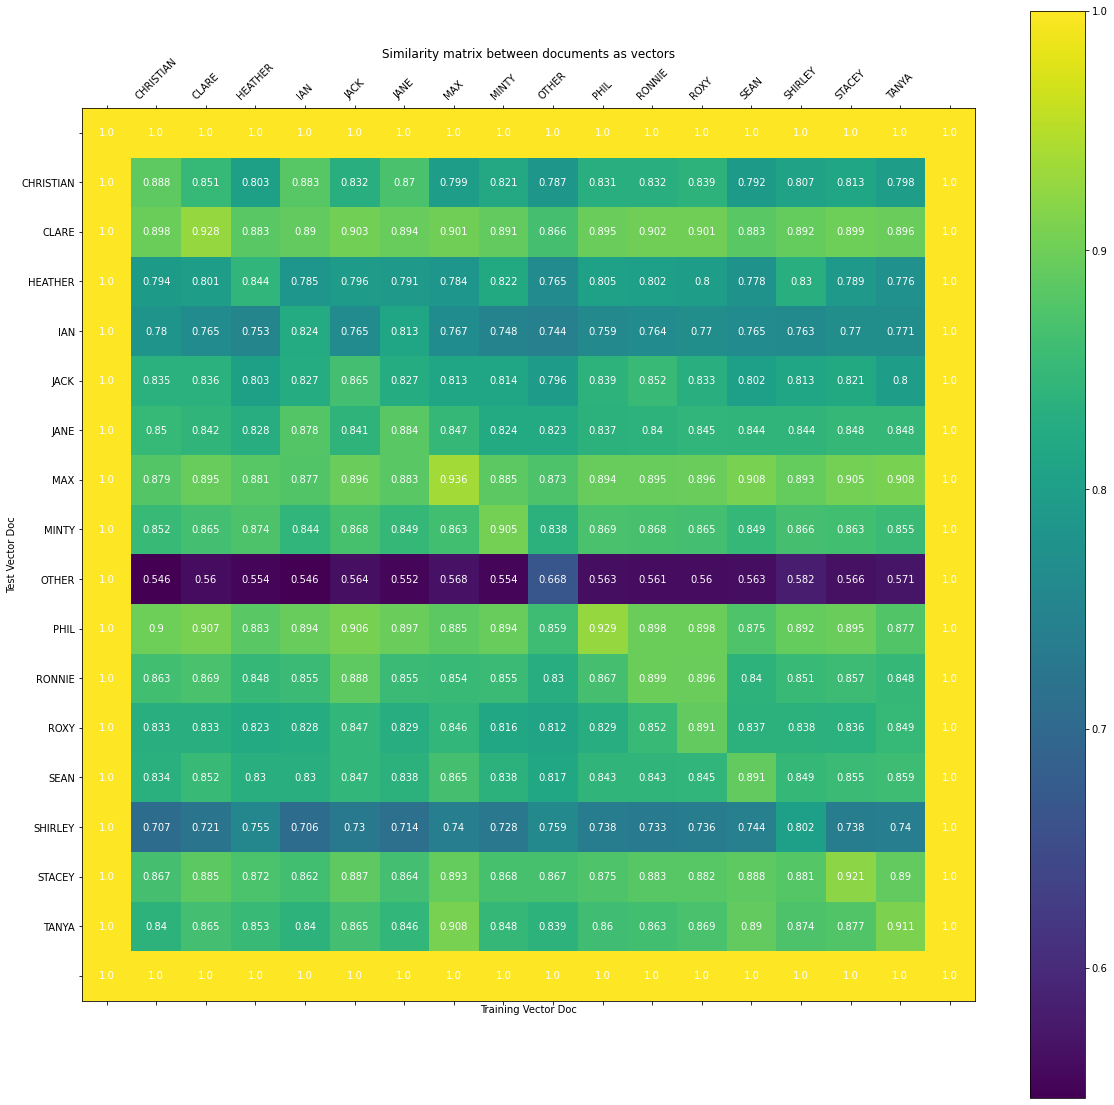

In [ ]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [ ]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    """
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    #lemmatize the text so we break down words in their correct context
    tokenLemmed = lemmatizer.lemmatize(character_text)
    # remove all punctuation using translate and maketrans functions
    tokenPuncStrip = tokenLemmed.translate(str.maketrans('', '', string.punctuation))
    # we stem the words which the lemmatizer has done for context words but now we break down even further.
    tokenStemmed = porter.stem(tokenPuncStrip)
    # tokenize into list
    tokenized = tokenStemmed.split()
    # remove stop words in the corpus
    tokens = [word for word in tokenized if word not in stopwords.words('english')]
    # remove eol
    tokensEol = [o for o in tokens if o not in ['eol']]

    tokensEol = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [ ]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
total_words = 0

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
total_words = 0

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}


# JUST PRE PROCESSING RESULTS - DEFAULT

In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1

    # add the extra features, for now just adding one count for each extra feature
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 2.5
mean cosine similarity 0.9405596536528162
9 correct out of 16 / accuracy: 0.5625


# JUST POS TAGS

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    genderBool = ""
    genderList = []
    altList = []
    cleanedList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list
    posTag = nltk.pos_tag(removeEol) # do pos tag

    counts = Counter(posTag)  # count for pos Tag
    counts = dict(counts)
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 2.125
mean cosine similarity 0.49695332457620855
11 correct out of 16 / accuracy: 0.6875


# SENTIMENT ANALYSIS

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    sentiList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list

    for word in removeEol: # loop through processed words and add pos/neg/neu tag based on compound score.
        sid = SIA()
        s = sid.polarity_scores(word)
        if s["compound"] > 0:
           senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"
        sentiTuple = (word, senti)
        sentiList.append(sentiTuple)

    print(sentiList)

    counts = Counter(sentiList)  # count
    counts = dict(counts)
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.875
mean cosine similarity 0.598418997836859
11 correct out of 16 / accuracy: 0.6875


# BIGRAMS

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    sentiList = []
    bigramTupleList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list


    bigrams = list(nltk.bigrams(removeEol))

    for both in zip(removeEol, bigrams): # loop through processed words and add pos/neg/neu tag based on compound score.
        bigramTupleList.append(both)

    print(bigramTupleList)
    counts = Counter(bigramTupleList)  # count
    counts = dict(counts)
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 5.4375
mean cosine similarity 0.07584681501703067
5 correct out of 16 / accuracy: 0.3125


# TRIGRAMS

In [ ]:
from nltk.metrics.association import TrigramAssocMeasures
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    sentiList = []
    trigramTupleList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list
    trigrams = list(nltk.trigrams(removeEol))

    for both in zip(removeEol, trigrams): # loop through processed words and add pos/neg/neu tag based on compound score.
        trigramTupleList.append(both)

    print(trigramTupleList)
    counts = Counter(trigramTupleList)  # count
    counts = dict(counts)
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 8.9375
mean cosine similarity 0.005055719458794733
1 correct out of 16 / accuracy: 0.0625


# POS AND SENTIMENT ANALYSIS

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    sentiList = []
    finalList = []
    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      cleanedList.append(newly2)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list

    for word in removeEol: # loop through processed words and add pos/neg/neu tag based on compound score.
        sid = SIA()
        s = sid.polarity_scores(word)
        if s["compound"] > 0:
           senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"
        sentiTuple = (senti)
        sentiList.append(sentiTuple)

    posTag = nltk.pos_tag(removeEol) # do pos tag

    for pos, seg in zip(posTag, sentiList):
        posAndSegTuple = (*pos, seg)
        finalList.append(posAndSegTuple)

    counts = Counter(finalList)  # count
    counts = dict(counts)
    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 2.125
mean cosine similarity 0.49695332457620855
11 correct out of 16 / accuracy: 0.6875


# GENDER CLASSIFICATION WITH NAIVE BAYES CLASSIFIER

In [ ]:
def gender_features(word):
     return {'last_letter': word[-1]}

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    altList = []
    maleList = []
    femaleList = []
    genderBool = ""

    for word in character_doc: # for every word tag the corresponding gender
      if word == "male":
        genderBool = "male"
      elif word == "female":
        genderBool = "female"
      word = word + '@' + genderBool
      altList.append(word)


    for cleanUp in altList: # remove unwanted tags
      newly = cleanUp.replace("male@male","")
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("eol@male", "")
      newly4 = newly3.replace("eol@female", "")
      if  "@male" in newly4:
        maleWord = newly4.split('@')[0]
        maleList.append(maleWord) # create male word array
      else:
        femaleWord = newly4.split('@')[0]
        femaleList.append(femaleWord) # create female word array


    maleRemoval = [x for x in maleList if x]  # remove empty elements from the arrays
    femaleRemoval = [x for x in femaleList if x]
    labeled_names = ([(name, 'male') for name in maleRemoval] + [(name, 'female') for name in femaleRemoval]) # create labelled data of the two lists created previously
    random.shuffle(labeled_names) # shuffle so fair
    featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names] # get last letter of each word
    featureSplit = int(0.9*len(featuresets)) # split 90/10
    train_set, test_set = featuresets[:featureSplit], featuresets[featureSplit:]
    classifier = nltk.NaiveBayesClassifier.train(train_set) # train anive bayes classifier on training set

    genderList = []
    for w in character_doc: # lopp through normal data
      predictedGenderWord = w +'@' + classifier.classify(gender_features(w)) # make prediction
      newly = predictedGenderWord.replace("male@male", "") # remove unwanted data
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("male@female", "")
      newly4 = newly3.replace("male@female", "")
      newly5 = newly4.replace("female@male", "")
      newly6 = newly5.replace("eol@female", "")
      newly7 = newly6.replace("eol@male", "")
      genderList.append(newly7) # append to new list

    genderList = [x for x in genderList if x]  #remove any empty elements

    counts = Counter(genderList)  # count
    counts = dict(counts)
    print(counts)

    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.5625
mean cosine similarity 0.5867267654374559
12 correct out of 16 / accuracy: 0.75


# GENDER CLASSIFICATION AND POS TAG

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    altList = []
    maleList = []
    femaleList = []
    genderBool = ""

    for word in character_doc: # for every word tag the corresponding gender
      if word == "male":
        genderBool = "male"
      elif word == "female":
        genderBool = "female"
      word = word + '@' + genderBool
      altList.append(word)


    for cleanUp in altList: # remove unwanted tags
      newly = cleanUp.replace("male@male","")
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("eol@male", "")
      newly4 = newly3.replace("eol@female", "")
      if  "@male" in newly4:
        maleWord = newly4.split('@')[0]
        maleList.append(maleWord) # create male word array
      else:
        femaleWord = newly4.split('@')[0]
        femaleList.append(femaleWord) # create female word array


    maleRemoval = [x for x in maleList if x]  # remove empty elements from the arrays
    femaleRemoval = [x for x in femaleList if x]
    labeled_names = ([(name, 'male') for name in maleRemoval] + [(name, 'female') for name in femaleRemoval]) # create labelled data of the two lists created previously
    random.shuffle(labeled_names) # shuffle so fair
    featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names] # get last letter of each word
    featureSplit = int(0.9*len(featuresets)) # split 90/10
    train_set, test_set = featuresets[:featureSplit], featuresets[featureSplit:]
    classifier = nltk.NaiveBayesClassifier.train(train_set) # train anive bayes classifier on training set

    genderList = []
    for w in character_doc: # lopp through normal data
      predictedGenderWord = w +'@' + classifier.classify(gender_features(w)) # make prediction
      newly = predictedGenderWord.replace("male@male", "") # remove unwanted data
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("male@female", "")
      newly4 = newly3.replace("male@female", "")
      newly5 = newly4.replace("female@male", "")
      newly6 = newly5.replace("eol@female", "")
      newly7 = newly6.replace("eol@male", "")
      genderList.append(newly7) # append to new list

    genderList = [x for x in genderList if x]  #remove any empty elements
    taggedGenderClassifier = nltk.pos_tag(genderList)
    print(taggedGenderClassifier)

    counts = Counter(taggedGenderClassifier)  # count
    counts = dict(counts)
    print(counts)

    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.625
mean cosine similarity 0.5808656827536036
11 correct out of 16 / accuracy: 0.6875


# GENDER CLASSIFICATION AND SENTIMENT ANALYSIS

In [ ]:
from pyparsing.core import WordEnd
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    altList = []
    maleList = []
    femaleList = []
    genderBool = ""

    for word in character_doc: # for every word tag the corresponding gender
      if word == "male":
        genderBool = "male"
      elif word == "female":
        genderBool = "female"
      word = word + '@' + genderBool
      altList.append(word)


    for cleanUp in altList: # remove unwanted tags
      newly = cleanUp.replace("male@male","")
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("eol@male", "")
      newly4 = newly3.replace("eol@female", "")
      if  "@male" in newly4:
        maleWord = newly4.split('@')[0]
        maleList.append(maleWord) # create male word array
      else:
        femaleWord = newly4.split('@')[0]
        femaleList.append(femaleWord) # create female word array


    maleRemoval = [x for x in maleList if x]  # remove empty elements from the arrays
    femaleRemoval = [x for x in femaleList if x]
    labeled_names = ([(name, 'male') for name in maleRemoval] + [(name, 'female') for name in femaleRemoval]) # create labelled data of the two lists created previously
    random.shuffle(labeled_names) # shuffle so fair
    featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names] # get last letter of each word
    featureSplit = int(0.9*len(featuresets)) # split 90/10
    train_set, test_set = featuresets[:featureSplit], featuresets[featureSplit:]
    classifier = nltk.NaiveBayesClassifier.train(train_set) # train anive bayes classifier on training set

    genderList = []
    for w in character_doc: # lopp through normal data
      sid = SIA()
      predictedGenderWord = w + '@' + classifier.classify(gender_features(w)) # make prediction
      newly = predictedGenderWord.replace("male@male", "") # remove unwanted data
      newly2 = newly.replace("female@female", "")
      newly3 = newly2.replace("male@female", "")
      newly4 = newly3.replace("male@female", "")
      newly5 = newly4.replace("female@male", "")
      newly6 = newly5.replace("eol@female", "")
      newly7 = newly6.replace("eol@male", "")
      if newly7 != "":
        s = sid.polarity_scores(newly7)
        if s["compound"] > 0:
            senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"

        sentiWord = (newly7,senti)
        genderList.append(sentiWord) # append to new list

    genderList = [x for x in genderList if x]  #remove any empty elements
    print(genderList)

    counts = Counter(character_doc)  # count
    counts = dict(counts)


    return counts

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.4375
mean cosine similarity 0.9622454784329217
12 correct out of 16 / accuracy: 0.75


# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

# PREV/NEXT LINES AND TAGGING EACH WORD WITH CORRESPONDING SCENE INFO

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    scenes = []
    prevLine = []
    nextLine = []
    sceneIndicator = 0
    sceneIndicator2 = 0
    count = 0
    i = 0
    # for morning - bring through scene info aswell.
    for episode, scene, line, gender, name, currentScene in zip(df.Episode,GetLines(df.Scene), GetLines(df.Line), df.Gender, df.Character_name, df.Scene_info):
        count += 1
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if scene[1] != scene[2] and count != 1: # if our current scene number is not the same as our next scene number AND not our first iteration then continue
            sceneIndicator = 0 # reset variables
            sceneIndicator2 = 1
            character_docs[name] += currentScene.replace(" ","") + "#" +  " " +  str(line[0]) + " " + str(line[1]) + " " + "ENDOFSCENE" + " " + " _EOL_ "
            character_line_count[name]+=1
        else:
          if sceneIndicator2 == 1:
            character_docs[name] += currentScene.replace(" ","") + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
            character_line_count[name]+=1
            sceneIndicator2 = 0
          else:
            if count == 1: # first iteration check
              character_docs[name] += currentScene.replace(" ","") + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1
            else:
              character_docs[name] += currentScene.replace(" ","") + "#" + " " +  str(line[0]) + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1

    print(character_docs)
    print("lines per character", character_line_count)
    return character_docs


In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #var and list declaration
    cleanedList = []
    sentiList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly = cleanUp.replace("female","")
      newly2 = newly.replace("male","")
      newly3 = newly2.replace("startofscene","")
      newly4 = newly3.replace("endofscene","")
      cleanedList.append(newly4)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list

    testing = []
    prevElem = 0
    for test in removeEol:
      if "#" in test:
        testing.append(test)
        prevElem = test
      else:
        newElem = test + "@" + prevElem
        sliced = newElem[:-1]
        testing.append(sliced)

    removeJustSceneElems = [ x for x in testing if "#" not in x ]

    for word in removeJustSceneElems: # loop through processed words and add pos/neg/neu tag based on compound score.
        sid = SIA()
        s = sid.polarity_scores(word.split('@')[0])
        if s["compound"] > 0:
           senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"
        sentiTuple = (word, senti)
        sentiList.append(sentiTuple)


    counts = Counter(sentiList)  # count
    counts = dict(counts)
    return counts

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# PREV/NEXT LINES AND SCENE NAME TAGS AND EPISODE/SCENE NUMBER TAGS (POOR RESULTS EVEN ON TRAINING)

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    scenes = []
    prevLine = []
    nextLine = []
    sceneIndicator = 0
    sceneIndicator2 = 0
    count = 0
    i = 0
    # for morning - bring through scene info aswell.
    for episode, scene, line, gender, name, currentScene, epScene in zip(df.Episode,GetLines(df.Scene), GetLines(df.Line), df.Gender, df.Character_name, df.Scene_info, df.episode_scene):
        count += 1
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if scene[1] != scene[2] and count != 1: # if our current scene number is not the same as our next scene number AND not our first iteration then continue
            sceneIndicator = 0 # reset variables
            sceneIndicator2 = 1
            character_docs[name] += currentScene.replace(" ","") + epScene + "#" +  " " +  str(line[0]) + " " + str(line[1]) + " " + "ENDOFSCENE" + " " + " _EOL_ "
            character_line_count[name]+=1
        else:
          if sceneIndicator2 == 1:
            character_docs[name] += currentScene.replace(" ","") + epScene  + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
            character_line_count[name]+=1
            sceneIndicator2 = 0
          else:
            if count == 1: # first iteration check
              character_docs[name] += currentScene.replace(" ","") + epScene  + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1
            else:
              character_docs[name] += currentScene.replace(" ","") + epScene + "#" + " " +  str(line[0]) + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1

    print(character_docs)
    print("lines per character", character_line_count)
    return character_docs


In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


mean rank 8.5
mean cosine similarity nan
1 correct out of 16 / accuracy: 0.0625


# PREV/NEXT LINES AND EPISODE/SCENE TAGS (POOR RESULTS EVEN ON TRAINING)

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    scenes = []
    prevLine = []
    nextLine = []
    sceneIndicator = 0
    sceneIndicator2 = 0
    count = 0
    i = 0
    # for morning - bring through scene info aswell.
    for episode, scene, line, gender, name, currentScene, epScene in zip(df.Episode,GetLines(df.Scene), GetLines(df.Line), df.Gender, df.Character_name, df.Scene_info, df.episode_scene):
        count += 1
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if scene[1] != scene[2] and count != 1: # if our current scene number is not the same as our next scene number AND not our first iteration then continue
            sceneIndicator = 0 # reset variables
            sceneIndicator2 = 1
            character_docs[name] +=  epScene + "#" +  " " +  str(line[0]) + " " + str(line[1]) + " " + "ENDOFSCENE" + " " + " _EOL_ "
            character_line_count[name]+=1
        else:
          if sceneIndicator2 == 1:
            character_docs[name] +=  epScene  + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
            character_line_count[name]+=1
            sceneIndicator2 = 0
          else:
            if count == 1: # first iteration check
              character_docs[name] +=  epScene  + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1
            else:
              character_docs[name] +=  epScene + "#" + " " +  str(line[0]) + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1

    print(character_docs)
    print("lines per character", character_line_count)
    return character_docs


In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


mean rank 8.5
mean cosine similarity nan
1 correct out of 16 / accuracy: 0.0625


# PREV/NEXT LINES WITH EPISODE SCENE NAME TAGS

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    scenes = []
    prevLine = []
    nextLine = []
    sceneIndicator = 0
    sceneIndicator2 = 0
    count = 0
    i = 0
    # for morning - bring through scene info aswell.
    for episode, scene, line, gender, name, currentScene, epScene in zip(df.Episode,GetLines(df.Scene), GetLines(df.Line), df.Gender, df.Character_name, df.Scene_info, df.episode_scene):
        count += 1
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if scene[1] != scene[2] and count != 1: # if our current scene number is not the same as our next scene number AND not our first iteration then continue
            sceneIndicator = 0 # reset variables
            sceneIndicator2 = 1
            character_docs[name] += currentScene.replace(" ","") + "#" +  " " +  str(line[0]) + " " + str(line[1]) + " " + "ENDOFSCENE" + " " + " _EOL_ "
            character_line_count[name]+=1
        else:
          if sceneIndicator2 == 1:
            character_docs[name] += currentScene.replace(" ","") + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
            character_line_count[name]+=1
            sceneIndicator2 = 0
          else:
            if count == 1: # first iteration check
              character_docs[name] += currentScene.replace(" ","") + "#" + " " +  "STARTOFSCENE" + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1
            else:
              character_docs[name] += currentScene.replace(" ","") + "#" + " " +  str(line[0]) + " " + str(line[1]) + " " + str(line[2]) + " _EOL_ "  # adding an end-of-line token
              character_line_count[name]+=1

    print(character_docs)
    print("lines per character", character_line_count)
    return character_docs


In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# JUST PREV/NEXT LINES (BEST RESULT)

In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
      #var and list declaration
    cleanedList = []
    sentiList = []

    for cleanUp in character_doc: # remove male and female tags from original data as illegal to tag directly.
      newly3 = newly2.replace("startofscene","")
      newly4 = newly3.replace("endofscene","")
      cleanedList.append(newly4)

    removalEmptyElements = [x for x in cleanedList if x]  # remove empty elements in list
    removeEol = [o for o in removalEmptyElements if o not in ['eol']] # remove eol tags in list

    for word in removeEol: # loop through processed words and add pos/neg/neu tag based on compound score.
        sid = SIA()
        s = sid.polarity_scores(word.split('@')[0])
        if s["compound"] > 0:
           senti = "pos"
        elif s["compound"] == 0:
          senti = "neu"
        else:
          senti = "neg"
        sentiTuple = (word, senti)
        sentiList.append(sentiTuple)

    print(sentiList)
    counts = Counter(sentiList)  # count
    counts = dict(counts)
    return counts

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# tfIdfVectorizer with min df = 0.1 and max df = 0.9

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.9)

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    if fitting:
        vectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = vectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])


    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# TFIDF TRANSFORMER WITH COUNT VECTORIZER

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
cv=CountVectorizer()
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    docs = [to_feature_vector_dictionary(doc) for name, doc in corpus]
    if fitting:
       word_count_vector=cv.fit_transform(docs)
       tfidf_transformer.fit(word_count_vector)
    count_vector=cv.transform(docs)
    doc_feature_matrix=tfidf_transformer.transform(count_vector)

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# TFIDF VEC WITH MORE FEATURES

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  11333
OTHER Number of Words:  9071
JACK Number of Words:  11200
RONNIE Number of Words:  11550
TANYA Number of Words:  10690
SEAN Number of Words:  11079
ROXY Number of Words:  11292
HEATHER Number of Words:  11963
MAX Number of Words:  11868
IAN Number of Words:  12062
JANE Number of Words:  11381
STACEY Number of Words:  11639
PHIL Number of Words:  12306
MINTY Number of Words:  12224
CHRISTIAN Number of Words:  11088
CLARE Number of Words:  11901
total words 182647
['startofscene', 'look', 'ya', 'mark', 'ya', 'think', 'youre', 'unlucky', 'man', 'shirl', 'going', 'im', 'gonna', 'get', 'help', 'oh', 'wheres', 'phone', 'oh', 'kevin', 'kevin', 'smashed', 'didnt', 'ya', 'kevin', 'kevin', 'wheres', 